# Natural Language Processing

## Word2Vec (Negative Sampling)

Let's work on negative-sampling based implementation of word2vec.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## 1. Define some very simple data for understanding

In [2]:
sentences = ["apple banana ice", "banana orange fruit", "orange ice fruit", "orange grapes fruit", "banana ice fruit", "grapes fruit ice",
                 "dog cat animal", "cat monkey animal", "monkey dog animal", "conda dog animal", "monkey dog conda", "monkey conda animal"]

In [3]:
#get word sequences
word_sequence = " ".join(sentences).split()
print(word_sequence)

['apple', 'banana', 'ice', 'banana', 'orange', 'fruit', 'orange', 'ice', 'fruit', 'orange', 'grapes', 'fruit', 'banana', 'ice', 'fruit', 'grapes', 'fruit', 'ice', 'dog', 'cat', 'animal', 'cat', 'monkey', 'animal', 'monkey', 'dog', 'animal', 'conda', 'dog', 'animal', 'monkey', 'dog', 'conda', 'monkey', 'conda', 'animal']


In [4]:
#get unique words
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
print(word_list)   

['animal', 'monkey', 'grapes', 'conda', 'orange', 'cat', 'fruit', 'banana', 'apple', 'ice', 'dog']


In [5]:
#numericalization
word_dict = {w: i for i, w in enumerate(word_list)}
print(word_dict)

{'animal': 0, 'monkey': 1, 'grapes': 2, 'conda': 3, 'orange': 4, 'cat': 5, 'fruit': 6, 'banana': 7, 'apple': 8, 'ice': 9, 'dog': 10}


In [6]:
#vocab size
voc_size = len(word_list)
print(voc_size)

11


In [7]:
word_sequence[16]

'fruit'

## 2. Make our skipgram batch loader

In [8]:
def random_batch(batch_size, word_sequence):
    
    # Make skip gram of one size window
    skip_grams = []
    # loop each word sequence
    # we starts from 1 because 0 has no context
    # we stop at second last for the same reason
    for i in range(1, len(word_sequence) - 1):
        target = word_dict[word_sequence[i]]  #banana is 6 so return 6        
        context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]] #left of banana is apple; right is fruit, so context is [4, 2]
        for w in context:
            skip_grams.append([target, w]) #e.g., [6, 4], [6, 2], so on... (target, context)
    
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) #randomly pick without replacement
    
    #make input and labels as one-hot encoding
    #we cannot train using taking integer as input...
    for i in random_index:
        random_inputs.append(np.eye(voc_size)[skip_grams[i][0]])  # target,e g., [0, 0, 0, 0, 0, 1, 0, 0]
        random_labels.append(skip_grams[i][1])  # context word, e.g., 3

    return np.array(random_inputs), np.array(random_labels)

### Testing the method

In [9]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch = random_batch(batch_size, word_sequence)

print("Input: ", input_batch)
print("Target: ", target_batch)

#we will convert them to tensor during training, so don't worry...

Input:  [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Target:  [2 6]


## 3. Model

In [10]:
class Word2Vec(nn.Module):
    def __init__(self, embedding_size):
        super(Word2Vec, self).__init__()
        # W and WT is not Traspose relationship
        self.W = nn.Linear(voc_size, embedding_size, bias=False) # voc_size > embedding_size Weight
        self.WT = nn.Linear(embedding_size, voc_size, bias=False) # embedding_size > voc_size Weight

    def forward(self, X):
        # X : [batch_size, voc_size]
        hidden_layer = self.W(X) # hidden_layer : [batch_size, embedding_size]
        output_layer = self.WT(hidden_layer) # output_layer : [batch_size, voc_size]
        return output_layer

## 4. Training

In [11]:
embedding_size = 2 #so we can later plot
model = Word2Vec(embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Training
num_epochs = 5000
for epoch in range(num_epochs):
    input_batch, target_batch = random_batch(batch_size, word_sequence)
    input_batch = torch.Tensor(input_batch)
    target_batch = torch.LongTensor(target_batch)

    optimizer.zero_grad()
    output = model(input_batch)

    # output : [batch_size, voc_size], target_batch : [batch_size] (LongTensor, not one-hot)
    loss = criterion(output, target_batch)
    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

Epoch: 1000 cost = 2.395988
Epoch: 2000 cost = 1.763380
Epoch: 3000 cost = 1.707680
Epoch: 4000 cost = 1.245237
Epoch: 5000 cost = 1.815973


## 5. Plotting the embeddings

In [13]:
W, WT = model.parameters()
W.shape #embedding (x, y), vocab (unique vocabs)

torch.Size([2, 11])

In [14]:
#x embedding of the first vocab
W[0][1].item()

-0.39345237612724304

In [15]:
#y embedding of the first vocab
W[1][1].item()

1.3749170303344727

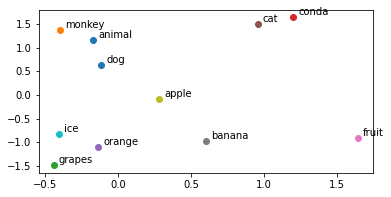

In [16]:
plt.figure(figsize=(6,3))
for i, label in enumerate(word_list): #loop each unique vocab
    W, WT = model.parameters()
    x, y = W[0][i].item(), W[1][i].item()
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

### 6. Cosine similarity

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [17]:
word_list

['animal',
 'monkey',
 'grapes',
 'conda',
 'orange',
 'cat',
 'fruit',
 'banana',
 'apple',
 'ice',
 'dog']

In [18]:
#let's try similarity between first and second, and second and third

#embedding = x, y, vocab = 0
first      = [W[0][0].item(), W[1][0].item()]
second     = [W[0][1].item(), W[1][1].item()]
third      = [W[0][2].item(), W[1][2].item()]

In [19]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim
    
print(f"{word_list[0]} vs. {word_list[1]}: ",   cos_sim(first, second))
print(f"{word_list[0]} vs. {word_list[2]}:",    cos_sim(second, third))
print(f"{word_list[0]} vs. {word_list[0]}: ",   cos_sim(first, first))

animal vs. monkey:  0.9907741916907582
animal vs. grapes: -0.8447612339937328
animal vs. animal:  1.0


In [20]:
#scipy version
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"{word_list[0]} vs. {word_list[1]}: ",   cos_sim(first, second))
print(f"{word_list[0]} vs. {word_list[2]}:",    cos_sim(second, third))
print(f"{word_list[0]} vs. {word_list[0]}: ",   cos_sim(first, first))

animal vs. monkey:  0.9907741916907584
animal vs. grapes: -0.8447612339937329
animal vs. animal:  1
